## Importing the relevant packages


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
from math import sqrt


# from jupyterthemes import jtplot
# jtplot.style(context='paper', grid=True, gridlines='--', fscale = 1.0, ticks=True)

custom_style = {
    "axes.labelcolor": "#424a5a",
    "grid.linestyle": "--",
    "xtick.color": "#424a5a",
    "ytick.color": "#424a5a",
}
# custom_style = {'axes.axisbelow': True,
#                'grid.color': '#424a5a'}
import seaborn as sns

sns.set(
    context="notebook",
    palette="nipy_spectral",
    style="whitegrid",
    font="sans-serif",
    font_scale=1,
    color_codes=True,
    rc=custom_style,
)

# These need to go after seaborn setttings:
# plt.style.use('seaborn-whitegrid')  #Best for White Backgrounds
plt.style.use("dark_background")  # Best for Black Backgrounds

# test 'Palette'
sns.palplot(sns.color_palette("nipy_spectral", 25))
# rocket YlGn plasma inferno pastel bright colorblind style='darkgrid',

## Importing the Data and Pre-processing 

In [2]:
# raw_csv_data = pd.read_csv("Index2018.csv") 
raw_csv_data = pd.read_csv("Close Price - 2019-07-07 5m.csv") 

# Copy raw data to a new dataframe
df_comp=raw_csv_data.copy()

# Convert timestamp to an official datetime
# df_comp.Timestamp = pd.to_datetime(df_comp.Timestamp, dayfirst=True) + pd.Timedelta(hours=-4)

# Set the index to the 'Timestamp'
# df_comp.set_index("Timestamp", inplace=True)

# df_comp=df_comp.asfreq('B')
# df_comp.resample('B')
# df_comp=df_comp.fillna(method='ffill')

# Check for null values
# df_comp.isnull().sum()

df_comp.head()


,Timestamp,SPY,DJI,RUT,GSPC,NVDA,FB,NPTN,MYO,SDOW,...,XOP,LEN,HL,ARRY,ITA,ADVM,TEUM,VALE,MIY,BKX
0,7/5/2019 19:55,297.890015,26925.58008,1574.360840,2990.679932,159.985001,196.149994,4.34,NaN,47.91,...,26.385000,48.279999,1.7136,46.875000,214.559998,12.15,2.850,13.129,13.87,99.636597
1,2019-07-05 19:50,297.924988,26894.14063,1574.448242,2986.830078,159.994995,196.389999,4.34,NaN,47.91,...,26.385000,48.240002,1.7200,46.930000,214.250000,12.12,2.830,13.110,13.87,99.411598
2,2019-07-05 19:45,298.079987,26911.43945,1574.404541,2988.780029,159.902298,196.740005,4.36,NaN,47.82,...,26.360001,48.200001,1.7300,46.915001,214.419998,12.13,2.855,13.110,13.86,99.519096
3,2019-07-05 19:40,298.049988,26907.55078,1573.938477,2988.479980,160.009995,196.779999,4.38,NaN,47.84,...,26.379999,48.195702,1.7250,46.904999,214.309998,12.14,2.855,13.095,13.85,99.527100
4,2019-07-05 19:35,298.109985,26907.92969,1574.398804,2989.070068,159.910004,196.779999,4.38,NaN,47.84,...,26.400000,48.230000,1.7300,46.904999,214.339996,12.19,2.830,13.085,13.85,99.568802


In [3]:
# reduce to just indicies of interest, for now
df_comp = df_comp[['SPY']]
# df_comp.head()

In [4]:
df_spy = df_comp.copy()

In [5]:
# del df_comp['spx']
# del df_comp['dax']
# del df_comp['ftse']
# del df_comp['nikkei']
size = int(len(df_spy)*0.8)
df, df_test = df_spy.iloc[:size], df_spy.iloc[size:]
df.head(10)

,SPY
0,297.890015
1,297.924988
2,298.079987
3,298.049988
4,298.109985
5,298.209992
6,298.350006
7,298.369995
8,298.160004
9,298.252502


## LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF=1):
    '''Tests Log Likelyhood for significance, based on RESULTS of ARIMA model,
    Passing the model now causes failure do to .fit() transforming the data'''
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## The DF-Test

In [7]:
sts.adfuller(df.SPY)

(-2.0191993639927808,
 0.2782188091468473,
 7,
 3708,
 {'1%': -3.432114787687694,
  '5%': -2.862319785536031,
  '10%': -2.5671850910332363},
 1091.1017743465118)

In [8]:
df.head()

,SPY
0,297.890015
1,297.924988
2,298.079987
3,298.049988
4,298.109985


## Using Returns

In [9]:
df['returns'] = df.SPY.pct_change(1).mul(100)
df = df.iloc[1:]

C:\Users\markh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
sts.adfuller(df.returns)

(-22.32274292949508,
 0.0,
 6,
 3708,
 {'1%': -3.432114787687694,
  '5%': -2.862319785536031,
  '10%': -2.5671850910332363},
 -6655.466531407528)

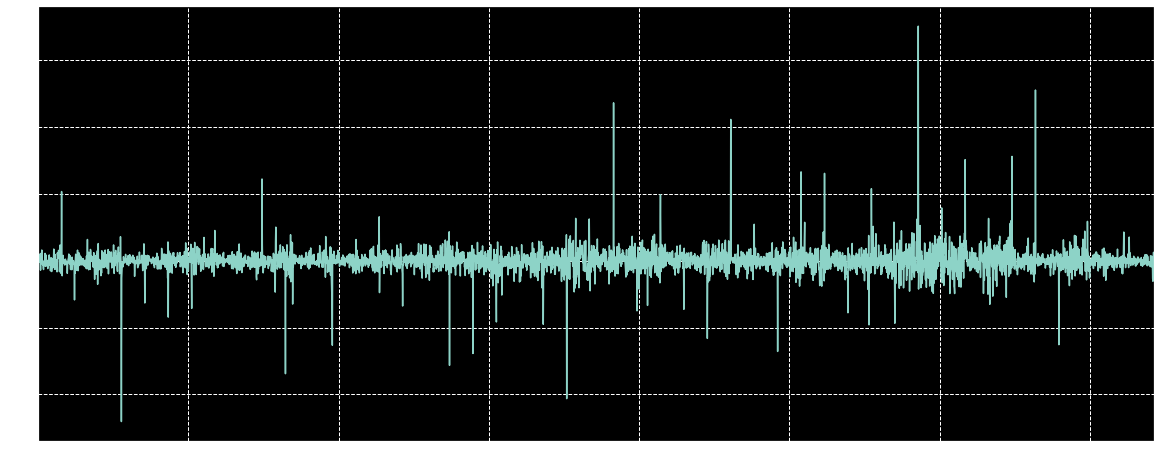

In [11]:
df.returns.plot(y='returns', figsize=(20,8));


In [12]:
# mini = df.returns.mean() - df.returns.std()
# maxi = df.returns.mean() + df.returns.std()
# print("The Min is: {0} \tThe Max is:{1}".format(mini, maxi))

# df[df.returns < mini] = mini
# df[df.returns > maxi] = maxi
# df.returns.plot(y='returns', figsize=(20,8))

# # df[df['SPY'] < mini] = mini
# # df[df['SPY'] > maxi] = maxi
# # df.pct_change().plot(y='SPY', figsize=(20,8));

## ACF and PACF for Returns

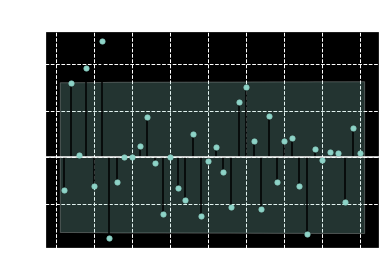

In [13]:
sgt.plot_acf(df.returns, lags=40, zero = False)
plt.title("ACF FTSE Returns", size=24)
plt.show()

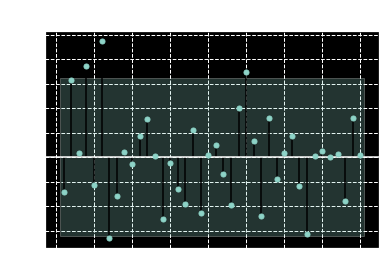

In [14]:
sgt.plot_pacf(df.returns, lags = 40, zero = False, method = ('ols'))
plt.title("PACF FTSE Returns", size=24)
plt.show()

## AR(1) for Returns

In [15]:
model_ret_ar_1 = ARMA(df.returns, order = (1,0))

In [16]:
results_ret_ar_1 = model_ret_ar_1.fit()

In [17]:
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 3715
Model:                     ARMA(1, 0)   Log Likelihood                3366.197
Method:                       css-mle   S.D. of innovations              0.098
Date:                Thu, 10 Oct 2019   AIC                          -6726.393
Time:                        09:10:56   BIC                          -6707.733
Sample:                             0   HQIC                         -6719.754
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.002     -0.260      0.795      -0.004       0.003
ar.L1.returns    -0.0141      0.016     -0.861      0.389      -0.046       0.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -70.7799           +0.0000j           70.7799            0.5000
-----------------------------------------------------------------------------
"""

## Higher-Lag AR Models for Returns

Interesting thing here, after running .fit() the model is converted to a bunch of constants, so...
not sure how to mitigate that for passing to the LLF function

[THIS](https://machinelearningmastery.com/tune-arima-parameters-python/) may be interesting to look into

In [18]:
# model_ret_ar_2 = ARMA(df.returns, order = (2,0), freq='5min')
model_ret_ar_2 = ARMA(df.returns, order = (2,0))
print(model_ret_ar_2)
results_ret_ar_2 = model_ret_ar_2.fit()
print(model_ret_ar_2)
results_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 3715
Model:                     ARMA(2, 0)   Log Likelihood                3368.035
Method:                       css-mle   S.D. of innovations              0.098
Date:                Thu, 10 Oct 2019   AIC                          -6728.071
Time:                        09:10:56   BIC                          -6703.190
Sample:                             0   HQIC                         -6719.218
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.002     -0.252      0.801      -0.004       0.003
ar.L1.returns    -0.0137      0.016     -0.834      0.404      -0.046       0.018
ar.L2.returns     0.0315      0.016      1.918      0.055      -0.001       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.4255           +0.0000j            5.4255            0.5000
AR.2            5.8605           +0.0000j            5.8605            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
results_ret_ar_2.llf

3368.0352893555473

In [20]:
# model_ret_ar_2.fit().llf  #<-- no longer works

In [21]:
LLR_test(results_ret_ar_1, results_ret_ar_2)

0.055

In [22]:
model_ret_ar_3 = ARMA(df.returns, order = (3,0))
results_ret_ar_3 = model_ret_ar_3.fit()
results_ret_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 3715
Model:                     ARMA(3, 0)   Log Likelihood                3368.041
Method:                       css-mle   S.D. of innovations              0.098
Date:                Thu, 10 Oct 2019   AIC                          -6726.083
Time:                        09:10:57   BIC                          -6694.982
Sample:                             0   HQIC                         -6715.017
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.002     -0.252      0.801      -0.004       0.003
ar.L1.returns    -0.0137      0.016     -0.837      0.402      -0.046       0.018
ar.L2.returns     0.0315      0.016      1.919      0.055      -0.001       0.064
ar.L3.returns     0.0018      0.016      0.110      0.913      -0.030       0.034
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.1281           +0.0000j            5.1281            0.0000
AR.2           -6.8891           +0.0000j            6.8891            0.5000
AR.3          -15.7276           +0.0000j           15.7276            0.5000
-----------------------------------------------------------------------------
"""

In [23]:
LLR_test(results_ret_ar_2, results_ret_ar_3)

0.913

In [24]:
model_ret_ar_4 = ARMA(df.returns, order = (4,0))
results_ret_ar_4 = model_ret_ar_4.fit()
print(results_ret_ar_4.summary())
print ("LLR test: " + str(LLR_test(results_ret_ar_3, results_ret_ar_4)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 3715
Model:                     ARMA(4, 0)   Log Likelihood                3370.618
Method:                       css-mle   S.D. of innovations              0.098
Date:                Thu, 10 Oct 2019   AIC                          -6729.237
Time:                        09:10:57   BIC                          -6691.916
Sample:                             0   HQIC                         -6715.958
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.002     -0.242      0.809      -0.004       0.003
ar.L1.returns    -0.0138      0.016     -0.842      0.400      -0.046       0.018
ar.L2.returns     0.0303      0.016     

In [25]:
model_ret_ar_5 = ARMA(df.returns, order = (5,0))
results_ret_ar_5 = model_ret_ar_5.fit()
print(results_ret_ar_5.summary())
print ("LLR test: " + str(LLR_test(results_ret_ar_4, results_ret_ar_5)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 3715
Model:                     ARMA(5, 0)   Log Likelihood                3370.864
Method:                       css-mle   S.D. of innovations              0.098
Date:                Thu, 10 Oct 2019   AIC                          -6727.728
Time:                        09:10:58   BIC                          -6684.187
Sample:                             0   HQIC                         -6712.236
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.002     -0.245      0.806      -0.004       0.003
ar.L1.returns    -0.0134      0.016     -0.816      0.415      -0.046       0.019
ar.L2.returns     0.0303      0.016     

In [26]:
model_ret_ar_6 = ARMA(df.returns, order = (6,0))
results_ret_ar_6 = model_ret_ar_6.fit()
print(results_ret_ar_6.summary())
print ("LLR test: " + str(LLR_test(results_ret_ar_5, results_ret_ar_6)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 3715
Model:                     ARMA(6, 0)   Log Likelihood                3375.046
Method:                       css-mle   S.D. of innovations              0.098
Date:                Thu, 10 Oct 2019   AIC                          -6734.092
Time:                        09:10:58   BIC                          -6684.331
Sample:                             0   HQIC                         -6716.386
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.002     -0.234      0.815      -0.004       0.003
ar.L1.returns    -0.0128      0.016     -0.783      0.434      -0.045       0.019
ar.L2.returns     0.0286      0.016     

In [27]:
model_ret_ar_7 = ARMA(df.returns, order = (7,0))
results_ret_ar_7 = model_ret_ar_7.fit()
results_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 3715
Model:                     ARMA(7, 0)   Log Likelihood                3377.089
Method:                       css-mle   S.D. of innovations              0.097
Date:                Thu, 10 Oct 2019   AIC                          -6736.178
Time:                        09:10:59   BIC                          -6680.197
Sample:                             0   HQIC                         -6716.260
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.002     -0.241      0.810      -0.004       0.003
ar.L1.returns    -0.0113      0.016     -0.686      0.493      -0.043       0.021
ar.L2.returns     0.0282      0.016      1.722      0.085      -0.004       0.060
ar.L3.returns     0.0037      0.016      0.226      0.821      -0.028       0.036
ar.L4.returns     0.0357      0.016      2.181      0.029       0.004       0.068
ar.L5.returns    -0.0099      0.016     -0.604      0.546      -0.042       0.022
ar.L6.returns     0.0470      0.016      2.868      0.004       0.015       0.079
ar.L7.returns    -0.0332      0.016     -2.022      0.043      -0.065      -0.001
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4114           -0.0000j            1.4114           -0.5000
AR.2           -0.8508           -1.2793j            1.5364           -0.3434
AR.3           -0.8508           +1.2793j            1.5364            0.3434
AR.4            0.5096           -1.5540j            1.6355           -0.1996
AR.5            0.5096           +1.5540j            1.6355            0.1996
AR.6            1.7552           -0.5514j            1.8398           -0.0484
AR.7            1.7552           +0.5514j            1.8398            0.0484
-----------------------------------------------------------------------------
"""

In [28]:
print (LLR_test(results_ret_ar_6, results_ret_ar_7))

0.043


## Normalizing Values

In [32]:
benchmark = df.returns.iloc[0]

In [34]:
df['norm'] = df.returns.div(benchmark).mul(100)

In [35]:
sts.adfuller(df.norm)

(-22.322742929495075,
 0.0,
 6,
 3708,
 {'1%': -3.432114787687694,
  '5%': -2.862319785536031,
  '10%': -2.5671850910332363},
 60024.17872710315)

In [36]:
bench_ret = df.returns.iloc[0]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)
sts.adfuller(df.norm_ret)

(-22.322742929495075,
 0.0,
 6,
 3708,
 {'1%': -3.432114787687694,
  '5%': -2.862319785536031,
  '10%': -2.5671850910332363},
 60024.17872710315)

## Normalized Returns

In [37]:
model_norm_ret_ar_1 = ARMA (df.norm_ret, order=(1,0))
results_norm_ret_ar_1 = model_norm_ret_ar_1.fit()
results_norm_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 3715
Model:                     ARMA(1, 0)   Log Likelihood              -30254.173
Method:                       css-mle   S.D. of innovations            832.847
Date:                Thu, 10 Oct 2019   AIC                          60514.346
Time:                        09:12:59   BIC                          60533.006
Sample:                             0   HQIC                         60520.985
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.5017     13.474     -0.260      0.795     -29.910      22.907
ar.L1.norm_ret    -0.0141      0.016     -0.861      0.389      -0.046       0.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -70.7792           +0.0000j           70.7792            0.5000
-----------------------------------------------------------------------------
"""

In [38]:
model_norm_ret_ar_2 = ARMA(df.norm_ret, order=(2,0))
results_norm_ret_ar_2 = model_norm_ret_ar_2.fit()
results_norm_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 3715
Model:                     ARMA(2, 0)   Log Likelihood              -30252.334
Method:                       css-mle   S.D. of innovations            832.434
Date:                Thu, 10 Oct 2019   AIC                          60512.668
Time:                        09:13:00   BIC                          60537.549
Sample:                             0   HQIC                         60521.521
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.5017     13.904     -0.252      0.801     -30.754      23.750
ar.L1.norm_ret    -0.0137      0.016     -0.834      0.404      -0.046       0.018
ar.L2.norm_ret     0.0315      0.016      1.918      0.055      -0.001       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.4255           +0.0000j            5.4255            0.5000
AR.2            5.8605           +0.0000j            5.8605            0.0000
-----------------------------------------------------------------------------
"""

In [39]:
model_norm_ret_ar_7 = ARMA(df.norm_ret, order=(7,0))
results_norm_ret_ar_7 = model_norm_ret_ar_7.fit()
results_norm_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 3715
Model:                     ARMA(7, 0)   Log Likelihood              -30243.280
Method:                       css-mle   S.D. of innovations            830.405
Date:                Thu, 10 Oct 2019   AIC                          60504.561
Time:                        09:13:02   BIC                          60560.542
Sample:                             0   HQIC                         60524.479
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.5568     14.497     -0.245      0.806     -31.971      24.857
ar.L1.norm_ret    -0.0113      0.016     -0.686      0.493      -0.043       0.021
ar.L2.norm_ret     0.0282      0.016      1.722      0.085      -0.004       0.060
ar.L3.norm_ret     0.0037      0.016      0.226      0.821      -0.028       0.036
ar.L4.norm_ret     0.0357      0.016      2.181      0.029       0.004       0.068
ar.L5.norm_ret    -0.0099      0.016     -0.604      0.546      -0.042       0.022
ar.L6.norm_ret     0.0470      0.016      2.868      0.004       0.015       0.079
ar.L7.norm_ret    -0.0332      0.016     -2.022      0.043      -0.065      -0.001
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4114           -0.0000j            1.4114           -0.5000
AR.2           -0.8508           -1.2793j            1.5364           -0.3434
AR.3           -0.8508           +1.2793j            1.5364            0.3434
AR.4            0.5096           -1.5540j            1.6355           -0.1996
AR.5            0.5096           +1.5540j            1.6355            0.1996
AR.6            1.7552           -0.5514j            1.8398           -0.0484
AR.7            1.7552           +0.5514j            1.8398            0.0484
-----------------------------------------------------------------------------
"""

## Analysing the Residuals

In [40]:
df['res_ret'] = results_ret_ar_6.resid

In [41]:
df.res_ret.mean()

-2.9419720786109336e-06

In [42]:
df.res_ret.var()

0.009517756903401326

In [43]:
sts.adfuller(df.res_ret)

(-60.8300030387807,
 0.0,
 0,
 3714,
 {'1%': -3.4321119346833497,
  '5%': -2.862318525286356,
  '10%': -2.5671844201204657},
 -6663.381392445477)

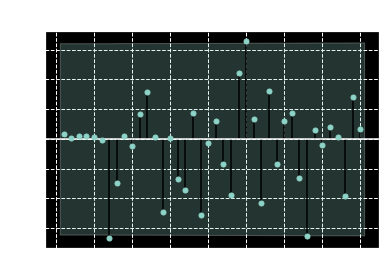

In [44]:
sgt.plot_acf(df.res_ret, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

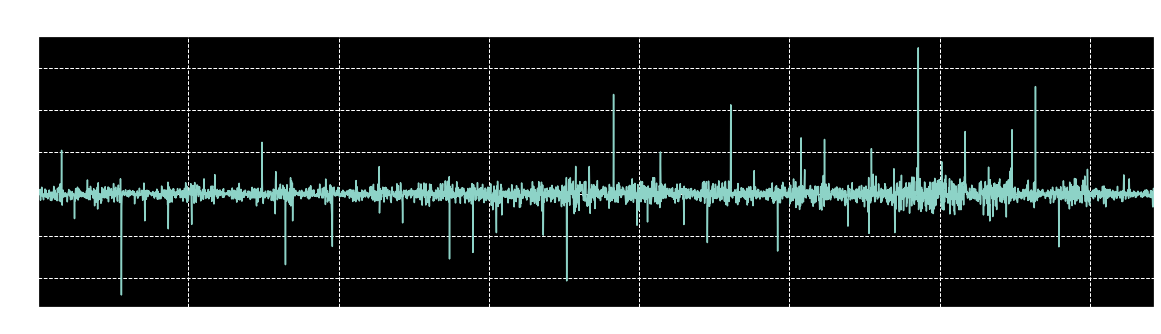

In [47]:
df.res_ret.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=32)
plt.show()

In [48]:
df.head()

,SPY,returns,norm,norm_ret,res_ret
1,297.924988,0.011740,100.000000,100.000000,0.012152
2,298.079987,0.052026,443.141047,443.141047,0.052610
3,298.049988,-0.010064,-85.721870,-85.721870,-0.009318
4,298.109985,0.020130,171.460997,171.460997,0.018736
5,298.209992,0.033547,285.739672,285.739672,0.033961
